In [1]:
import torch
import torch.nn as nn

import math

import mne

import matplotlib.pyplot as plt

import numpy as np

In [31]:
# pulled from Dr. Karpathy's minGPT implementation
class GELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

In [32]:
class BrainDecoderBlock(nn.Module):
    def __init__(self, k, input_dims=320, skip=True):
        super().__init__()

        self.skip = skip

        self.conv1 = nn.Conv1d(input_dims, 320, kernel_size=3, dilation=2**((2*k)%5), padding="same")
        self.conv2 = nn.Conv1d(320, 320, kernel_size=3, dilation=2**((2*k+1)%5), padding="same")
        self.conv3 = nn.Conv1d(320, 640, kernel_size=3, dilation=2, padding="same")

        self.bnorm1 = nn.BatchNorm1d(320)
        self.bnorm2 = nn.BatchNorm1d(320)

        self.gelu = GELU()

        # channel dim
        self.glu = nn.GLU(dim=1)

    def forward(self, x):
        output = self.conv1(x)
        output = self.bnorm1(output)
        output = self.gelu(output)

        if self.skip:
            # channel dim res connection
            output = output + x

            skip = output

        output = self.conv2(output)
        output = self.bnorm2(output)
        output = self.gelu(output)

        if self.skip:
            output = output + skip

        output = self.conv3(output)
        output = self.glu(output)

        return output

In [33]:
block = BrainDecoderBlock(1, input_dims=270, skip=False)

# batch_size, C, T
test_data = torch.randn((32, 270, 3600))

output = block(test_data)

print(output.shape)

torch.Size([32, 320, 3600])


/tmp/ipykernel_12523/1377067060.py:2: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  easycap_montage.plot()


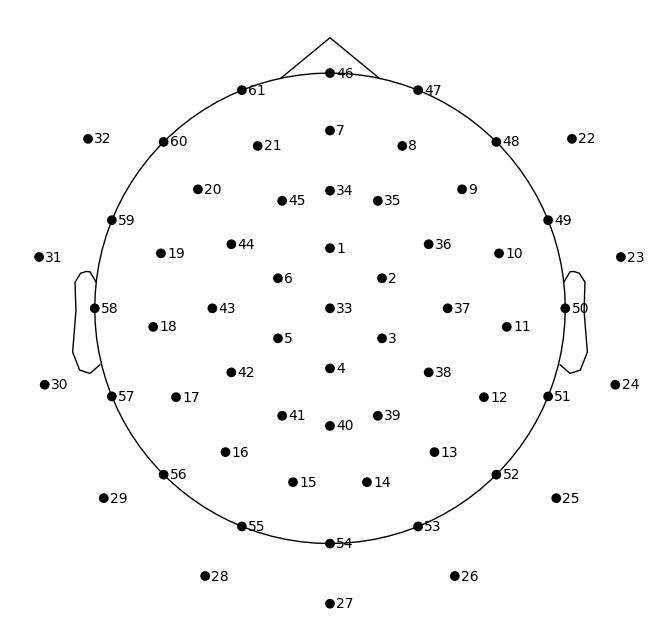

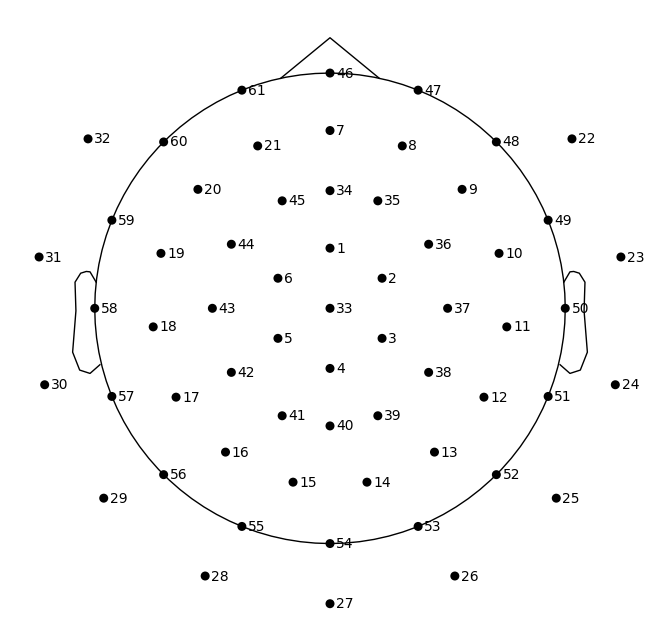

In [2]:
easycap_montage = mne.channels.read_custom_montage("./data/umich/electrode_positions.sfp")
easycap_montage.plot()

In [3]:
positions = easycap_montage.get_positions()
positions["ch_pos"]

OrderedDict([('1', array([0.        , 0.03712375, 0.08745246])),
             ('2', array([0.03214155, 0.0185566 , 0.08745246])),
             ('3', array([ 0.03214155, -0.0185566 ,  0.08745246])),
             ('4', array([ 0.        , -0.03712375,  0.08745246])),
             ('5', array([-0.03214155, -0.0185566 ,  0.08745246])),
             ('6', array([-0.03214155,  0.0185566 ,  0.08745246])),
             ('7', array([0.        , 0.0880858 , 0.03558265])),
             ('8', array([0.03582543, 0.08046471, 0.03558265])),
             ('9', array([0.06545477, 0.05894201, 0.03558265])),
             ('10', array([0.08376859, 0.02722268, 0.03558265])),
             ('11', array([ 0.08760024, -0.00920441,  0.03558265])),
             ('12', array([ 0.07628473, -0.04403762,  0.03558265])),
             ('13', array([ 0.05177482, -0.0712603 ,  0.03558265])),
             ('14', array([ 0.01831382, -0.08615413,  0.03558265])),
             ('15', array([-0.01831382, -0.08615413,  0.03558

/tmp/ipykernel_12523/2885659014.py:2: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(easycap_montage, on_missing="ignore")


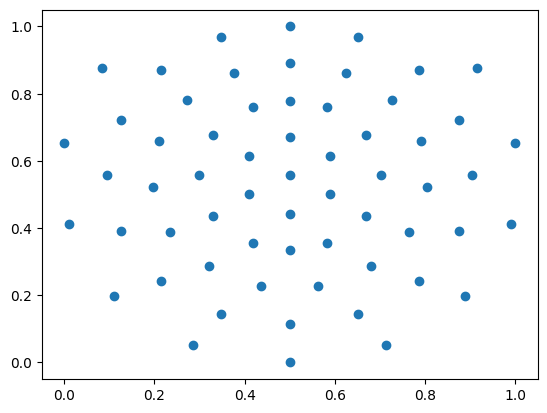

In [4]:
info = mne.create_info([str(i+1) for i in range(61)], sfreq=500, ch_types="eeg")
info.set_montage(easycap_montage, on_missing="ignore")

layout = mne.channels.find_layout(info)
two_dim_pos = layout.pos[:, :2]

# normalize 0-1
two_dim_pos[:, 0] -= min(two_dim_pos[:, 0])
two_dim_pos[:, 1] -= min(two_dim_pos[:, 1])

two_dim_pos[:, 0] /= max(two_dim_pos[:, 0])
two_dim_pos[:, 1] /= max(two_dim_pos[:, 1])

plt.scatter(two_dim_pos[:, 0], two_dim_pos[:, 1])

In [19]:
# compare runtime speeds of matrix vs. loop
import time

K = 32
C = 61
O = 270

z_trainable = torch.randn(O, K, K, dtype=torch.cfloat)
input_channels = torch.tensor(two_dim_pos)


curr_time = time.time()

a_j = 0

for _, channel in enumerate(input_channels):
    for k in range(1, K+1):
        for l in range(1, K+1):
            a_j += (z_trainable[:, k-1, l-1].real) * (torch.cos(2 * np.pi * (k * channel[0] + l * channel[1]))) + \
                (z_trainable[:, k-1, l-1].imag) * (torch.sin(2 * np.pi * (k * channel[0] + l * channel[1])))

print("Loop time: " + str(time.time() - curr_time))


'''
k -> 32, 32
input_channels[:, 0] -> 61, 1
z_trainable.real -> 270, 32, 32
'''

# matrix version
k = l = torch.linspace(1, K, K).repeat(C, K, 1).type(torch.float32)


curr_time = time.time()

term_1 = torch.transpose(torch.cos(2 * np.pi * (k * input_channels[:, 0].view(-1, 1, 1) + torch.transpose(l, 1, -1) * input_channels[:, 1].view(1, -1, 1, 1))), 2, 3)
term_2 = torch.transpose(torch.sin(2 * np.pi * (k * input_channels[:, 0].view(-1, 1, 1) + torch.transpose(l, 1, -1) * input_channels[:, 1].view(1, -1, 1, 1))), 2, 3)

z_trainable = torch.transpose(z_trainable.view(1, O, K, K).repeat(C, 1, 1, 1), 0, 1)

a_j = torch.sum(z_trainable.real * term_1 + z_trainable.imag * term_2, dim=(1, 2, 3))

print("Matrix time: " + str(time.time() - curr_time))


def a_j_softmax_activation():
    pass

Loop time: 4.545717716217041
Matrix time: 0.08891057968139648


In [55]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels, out_channels, num_harmonics):
        super().__init__()
        # position preprocessing
        easycap_montage = mne.channels.read_custom_montage("./data/umich/electrode_positions.sfp")

        info = mne.create_info([str(i+1) for i in range(in_channels)], sfreq=500, ch_types="eeg")
        info.set_montage(easycap_montage, on_missing="ignore")

        layout = mne.channels.find_layout(info)
        two_dim_pos = layout.pos[:, :2]

        # normalize 0-1
        two_dim_pos[:, 0] -= min(two_dim_pos[:, 0])
        two_dim_pos[:, 1] -= min(two_dim_pos[:, 1])

        two_dim_pos[:, 0] /= max(two_dim_pos[:, 0])
        two_dim_pos[:, 1] /= max(two_dim_pos[:, 1])

        self.input_channels = torch.tensor(two_dim_pos)
        
        # spatial attention calculation params

        self.z_trainable = torch.randn(out_channels, num_harmonics, num_harmonics, dtype=torch.cfloat)
        self.z_trainable = torch.nn.parameter.Parameter(torch.transpose(self.z_trainable.view(1, out_channels, num_harmonics, num_harmonics).repeat(in_channels, 1, 1, 1), 0, 1))

        self.k = self.l = torch.linspace(1, num_harmonics, num_harmonics).repeat(in_channels, num_harmonics, 1)

        # other stuff
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1)

        self.softmax = nn.Softmax()

    def forward(self, x):
        # x dims - batch_size, C, T

        term_1 = torch.transpose(torch.cos(2 * np.pi * (self.k * self.input_channels[:, 0].view(-1, 1, 1) + torch.transpose(self.l, 1, -1) * self.input_channels[:, 1].view(1, -1, 1, 1))), 2, 3)
        term_2 = torch.transpose(torch.sin(2 * np.pi * (self.k * self.input_channels[:, 0].view(-1, 1, 1) + torch.transpose(self.l, 1, -1) * self.input_channels[:, 1].view(1, -1, 1, 1))), 2, 3)

        a_j = torch.sum(self.z_trainable.real * term_1 + self.z_trainable.imag * term_2, dim=(1, 2, 3)).repeat(x.shape[0], 1).view(x.shape[0], -1, 1)

        output = self.conv1(x)

        output = a_j * output

        return output.type(torch.float32)

In [56]:
spatial_attention = SpatialAttention(in_channels=61, out_channels=270, num_harmonics=32)

# batch_size, C, T
test_data = torch.randn((32, 61, 3600))

output = spatial_attention(test_data)
output.shape

/tmp/ipykernel_12523/2599812541.py:8: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(easycap_montage, on_missing="ignore")


torch.Size([32, 270, 3600])

In [57]:
class BrainDecoder(nn.Module):
    def __init__(self, input_channels, num_k, num_freq_bands):
        super().__init__()

        self.spatial_attention = SpatialAttention(input_channels, 270, 32)

        self.conv1 = nn.Conv1d(270, 270, kernel_size=1)
        self.subject_layer = nn.Conv1d(270, 270, kernel_size=1)

        self.decoder_blocks = []

        for i in range(num_k):
            if i == 0:
                self.decoder_blocks += [BrainDecoderBlock(i+1, 270, False)]
            else:
                self.decoder_blocks += [BrainDecoderBlock(i+1, 320, True)]

        self.decoder_blocks = nn.ModuleList(self.decoder_blocks)

        self.conv2 = nn.Conv1d(320, 640, kernel_size=1)
        self.final_conv = nn.Conv1d(640, num_freq_bands, kernel_size=1)

    def forward(self, x):
        output = self.spatial_attention(x)

        output = self.conv1(output)
        output = self.subject_layer(output)

        for block in self.decoder_blocks:
            output = block(output)
        
        output = self.conv2(output)
        output = self.final_conv(output)

        return output

In [58]:
C = 61
F = 100
T = 3600

brain_decoder = BrainDecoder(input_channels=C, num_k=5, num_freq_bands=F)

# batch_size, C, T
test_data = torch.randn((32, C, T))

# expected output dims: batch_size, F, T
output = brain_decoder(test_data)
output.shape

/tmp/ipykernel_12523/2599812541.py:8: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(easycap_montage, on_missing="ignore")


torch.Size([32, 100, 3600])